## Importings and Parameters

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Parametreler
block_size = 1024  # Her sequence block_size kadar basamaktan oluşacak
batch_size = 2
learning_rate = 0.00001
max_iters = 1000
h1 = 512
h2 = 256
h3 = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Handling the Data

In [7]:
def load_pi_digits(file_path):
    with open(file_path, 'r') as file:
        pi_digits = file.read().strip()  
    return pi_digits

pi_digits = load_pi_digits('pi3-100-million.txt')

# Veriyi küçültme
#pi_digits = pi_digits[:1000000] 

pi_digits = [int(digit) for digit in str(pi_digits)]

data = torch.tensor(pi_digits, dtype=torch.long)

n = int(0.9 * len(data))  # İlk %90'ı eğitim, geri kalanı doğrulama
train_data = data[:n]
val_data = data[n:]

## Getting Batches

In [8]:
import random

def get_batch(split):
    data = train_data if split == 'train' else val_data
    maxix = len(data) - block_size - 1
    ix = random.randint(0, maxix)
    x = data[ix:ix+block_size]
    y = data[ix + block_size] if ix + block_size < len(data) else None
    return x,y

## Neural Network

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, h1, h2, h3, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, output_size) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        return x

## Creating Optimizer, Learning Schedule, Loss

In [10]:
# Model, kayıp fonksiyonu ve optimizer tanımlama
model = SimpleNN(input_size=block_size, h1=h1, h2=h2, h3=h3, output_size=10)

criterion = nn.CrossEntropyLoss()  # CrossEntropy sınıflandırma kaybı
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler ekler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)

## Calculating Accuracy

In [11]:
def calculate_accuracy():
    model.eval()
    x,y = get_batch("validation")

    with torch.no_grad():
        output = model(x.float())

        max_value, predicted_class = torch.max(output, dim=0)

        #print(f"predicted: {predicted_class} | real: {y}")

        if y == predicted_class:
            return 1
        else:
            return 0

## Training

In [12]:
lr_values = []
losses = []
accuracy_per = []
correct_predictions = 0
total_predictions = 0

for i in range(max_iters):
    x,y = get_batch("train")

    # Convert x to float and y to a tensor
    x = x.float().unsqueeze(0)  # Reshape x to (1, block_size)
    y = torch.tensor([y], dtype=torch.long)  # Make sure y is a tensor of shape (1)

    y_train = model.forward(x)

    correct_predictions += calculate_accuracy()
    total_predictions += 1

    loss = criterion(y_train, y)
    accuracy = correct_predictions/total_predictions * 100

    losses.append(loss.detach().numpy())
    accuracy_per.append(accuracy)
    lr_values.append(scheduler.get_last_lr()[0])

    if i % 50 == 0:
        print(f"iter: {i} | loss: {loss} | accuracy: {accuracy}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

iter: 0 | loss: 2.2391529083251953 | accuracy: 0.0
iter: 50 | loss: 2.6462297439575195 | accuracy: 7.8431372549019605
iter: 100 | loss: 2.0547266006469727 | accuracy: 8.91089108910891
iter: 150 | loss: 2.381603479385376 | accuracy: 10.596026490066226
iter: 200 | loss: 2.5695478916168213 | accuracy: 9.950248756218906
iter: 250 | loss: 2.399547815322876 | accuracy: 8.764940239043826
iter: 300 | loss: 2.3748931884765625 | accuracy: 8.305647840531561
iter: 350 | loss: 2.3888468742370605 | accuracy: 7.6923076923076925
iter: 400 | loss: 2.3979501724243164 | accuracy: 8.728179551122196
iter: 450 | loss: 2.493983745574951 | accuracy: 8.425720620842572
iter: 500 | loss: 2.047896385192871 | accuracy: 8.982035928143713
iter: 550 | loss: 2.3697760105133057 | accuracy: 8.52994555353902
iter: 600 | loss: 1.9338935613632202 | accuracy: 8.985024958402663
iter: 650 | loss: 2.163886547088623 | accuracy: 9.216589861751153
iter: 700 | loss: 2.286367654800415 | accuracy: 9.272467902995722
iter: 750 | loss:

## Graphs

Text(0.5, 0, 'epochs')

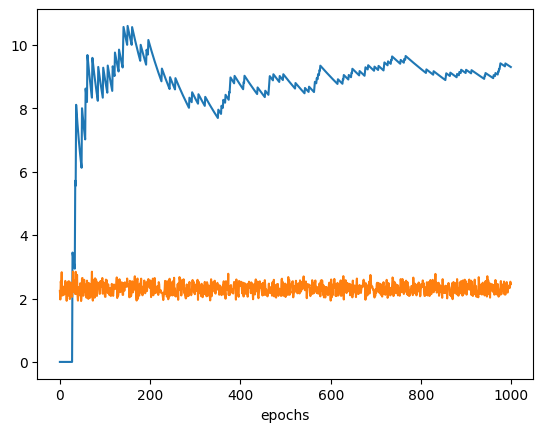

In [13]:
plt.plot(range(max_iters) , accuracy_per)
plt.plot(range(max_iters) , losses)
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

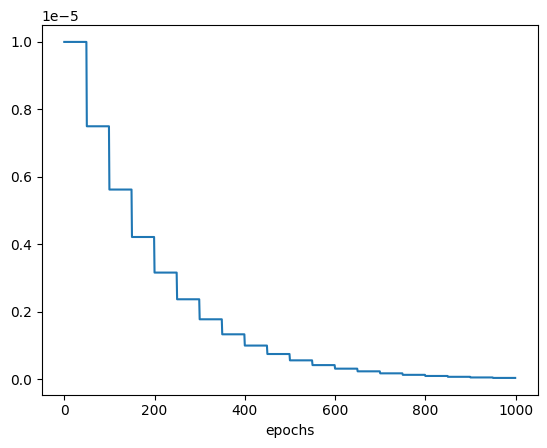

In [14]:
plt.plot(range(max_iters) , lr_values)
plt.xlabel("epochs")

## Manual Detection

In [35]:
model.eval()
x,y = get_batch("validation")
with torch.no_grad():
    output = model(x.float())
    _, predicted = torch.max(output, dim=0)

    print(f"predicted: {predicted} | real: {y} | real sequence: {x}")
    print(output)

predicted: 0 | real: 6 | real sequence: tensor([7, 4, 1,  ..., 5, 0, 5])
tensor([ 0.1785,  0.0364, -0.1474, -0.0930, -0.0988,  0.1293,  0.1351, -0.0975,
         0.0521,  0.1748])
